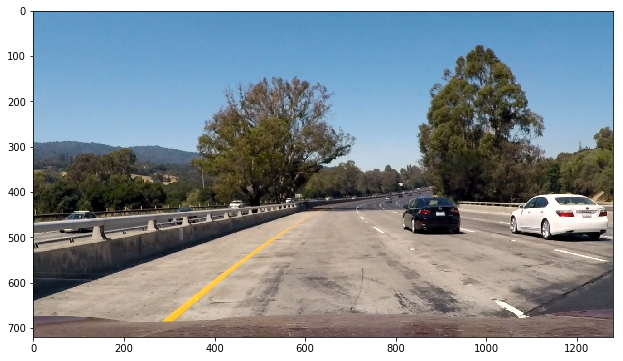

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

filename = './test_images/test1.jpg'

image = cv2.imread(filename)
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

(720, 1280, 3)


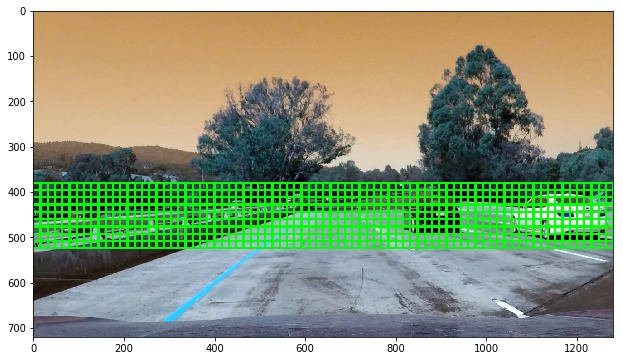

In [10]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        top_left = bbox[0]
        bottom_right = bbox[1]
        cv2.rectangle(imcopy, (top_left[0], top_left[1]), (bottom_right[0], bottom_right[1]), color, thick)
    return imcopy

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    x_start = x_start_stop[0] if x_start_stop[0] else 0
    y_start = y_start_stop[0] if y_start_stop[0] else 0
    x_stop = x_start_stop[1] if x_start_stop[1] else img.shape[0]
    y_stop = y_start_stop[1] if y_start_stop[1] else img.shape[1]
    window_w = xy_window[0]
    window_h = xy_window[1]
    
    x_step = np.int(window_w * xy_overlap[0])
    y_step = np.int(window_h * xy_overlap[1])
    x_stop = x_stop - window_w
    y_stop = y_stop - window_h
    
    for top in range(y_start, y_stop+1, y_step):
        for left in range(x_start, x_stop+1, x_step):
            top_left = (top, left)
            bottom_right = (top + window_w, left + window_h)
            window_list.append((top_left, bottom_right))
            
    return window_list

print(image.shape)
# windows = slide_window(image, x_start_stop=(400, 720), y_start_stop=(0,1280), xy_window=(128, 128), xy_overlap=(0.2, 0.2))
# window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=3)                    
windows = slide_window(image, x_start_stop=(380, 530), y_start_stop=(0,1280), xy_window=(64, 64), xy_overlap=(0.25, 0.25))
window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=3)
# windows = slide_window(image, x_start_stop=(330, 650), y_start_stop=(0,1280), xy_window=(192, 192), xy_overlap=(0.1, 0.1))
# window_img = draw_boxes(image, windows, color=(255, 255, 0), thick=3)    
# windows = slide_window(image, x_start_stop=(380, 720), y_start_stop=(0,1280), xy_window=(150, 150), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(image, windows, color=(255, 0, 0), thick=3)                    



plt.figure(figsize=(12, 6))
plt.imshow(window_img)
plt.show()

def window_img(img, window):
    top_left, bottom_right = window
    square_img = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0], :]
    return square_img

# windows = slide_window(image, x_start_stop=(380, 480), y_start_stop=(450,880), xy_window=(64, 64), xy_overlap=(0.5, 0.5))
# window_img = draw_boxes(image, windows, color=(0, 255, 0), thick=3)                    

# windows = slide_window(image, x_start_stop=(380, 572), y_start_stop=(350,1050), xy_window=(128, 128), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(window_img, windows, color=(0, 0, 255), thick=3)                    

# windows = slide_window(image, x_start_stop=(380, 650), y_start_stop=(250,1280), xy_window=(192, 192), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(window_img, windows, color=(255, 255, 0), thick=3)                    

# windows = slide_window(image, x_start_stop=(380, 720), y_start_stop=(150,1280), xy_window=(256, 256), xy_overlap=(0.25, 0.25))
# window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=3)                    



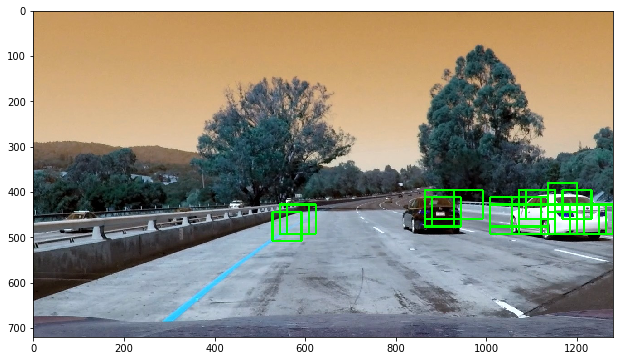

In [13]:
import pickle
from skimage.feature import hog


convertors = {
    'RGB': cv2.COLOR_BGR2RGB,
    'HLS': cv2.COLOR_BGR2HLS,
    'YUV': cv2.COLOR_BGR2YUV,
    'YCrCb': cv2.COLOR_BGR2YCrCb,
    'Lab': cv2.COLOR_BGR2Lab,
    'Luv': cv2.COLOR_BGR2Luv,
}

def color_hist(img, nbins=32, bins_range=(0, 256), color_space='RGB', visualize=False):
    convertor = convertors[color_space]
    img = cv2.cvtColor(img, convertor)
    hist0 = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    hist1 = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    hist2 = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    features = np.concatenate((hist0[0], hist1[0], hist2[0]))
    if visualize:
        return features, (hist0, hist1, hist2)
    else:
        return features
    
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    convertor = convertors[color_space]
    feature_img = cv2.cvtColor(img, convertor)
    features = cv2.resize(feature_img, size).ravel()
    return features

def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=False):
    return hog(
        img, orient, 
        pixels_per_cell=(pix_per_cell, pix_per_cell),
        cells_per_block=(cell_per_block, cell_per_block),
        visualise=vis, feature_vector=feature_vec)

def extract_features(img):    
    yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    channel1 = get_hog_features(yuv_img[:,:,0]).ravel()
    channel2 = get_hog_features(yuv_img[:,:,1]).ravel()
    channel3 = get_hog_features(yuv_img[:,:,2]).ravel()

    return np.concatenate((channel1, channel2, channel3))


classifier, feature_select, X_scaler = None, None, None
with open('./classifier.pkl', 'rb') as f:
    data = pickle.load(f)
    classifier = data['classifier1']
    X_scaler = data['X_scaler']

def is_vehicle(img):
    img = cv2.resize(img, (64, 64))
    X = extract_features(img).astype(np.float64)
    scaled_X = X_scaler.transform(X)
    X_new = feature_select.transform(scaled_X).ravel()
    result = classifier.predict([X_new])
    return result == 1
    
features = []
    
for window in windows:
    square_img = window_img(image, window)
    feature = extract_features(square_img)
    features.append(feature)

X = np.array(features)
X_scaled = X_scaler.transform(X)
car_incides = np.nonzero(classifier.predict(X_scaled))
windows_array = np.array(windows)

car_windows = windows_array[car_incides]
    
img_with_boxes = draw_boxes(image, car_windows, color=(0, 255, 0), thick=3)                    
plt.figure(figsize=(12, 6))
plt.imshow(img_with_boxes)
plt.show()


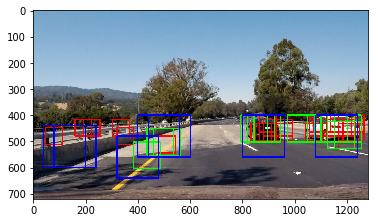

In [69]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

dist_pickle = pickle.load( open("classifier.pkl", "rb" ) )
svc = dist_pickle["classifier1"]
X_scaler = dist_pickle["X_scaler"]
orient = 9
pix_per_cell = 8
cell_per_block = 1

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=True):
    features = hog(img, orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   visualise=False, feature_vector=feature_vec)
    return features


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block):
    
    car_windows = []
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YUV)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)
    nyblocks = (ch1.shape[0] // pix_per_cell) 
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Scale features and make a prediction
            test_features = X_scaler.transform(hog_features)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows
    
ystart = 400
ystop = 656
scale = 1.0
# ystart, ystop, scale
searches = [
    (400, 656, 1.0, (0, 0, 255)),
    (400, 700, 1.6, (0, 255, 0)),
    (400, 720, 2.5, (255, 0, 0)),
]

bbox_list = []

filename = './test_images/test4.jpg'
img = cv2.imread(filename)
draw_img = np.copy(img)
for ystart, ystop, scale, color in searches:
    bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    if len(bboxes) > 0:
        bbox_list.append(bboxes)
    draw_img = draw_boxes(draw_img, bboxes, color=color, thick=3)

plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.show()

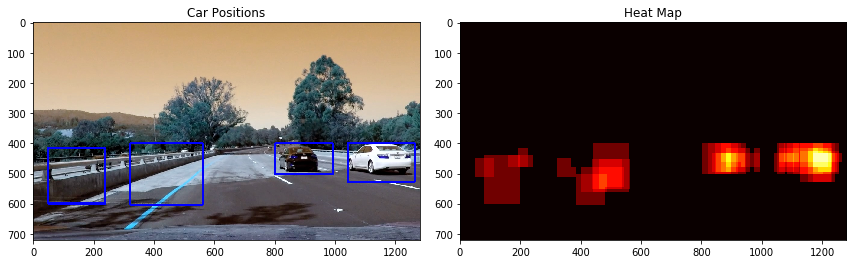

In [70]:
# Draw heatmap
from scipy.ndimage.measurements import label


def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap


def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat, np.concatenate(bbox_list))

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()